In [1]:
import wfdb
import pywt

import os
import numpy as np
from glob import glob

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split as tts
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix

import pickle

In [8]:
wfdb.dl_database('mitdb', dl_dir = 'mit_bih')

Generating record list for: 100
Generating record list for: 101
Generating record list for: 102
Generating record list for: 103
Generating record list for: 104
Generating record list for: 105
Generating record list for: 106
Generating record list for: 107
Generating record list for: 108
Generating record list for: 109
Generating record list for: 111
Generating record list for: 112
Generating record list for: 113
Generating record list for: 114
Generating record list for: 115
Generating record list for: 116
Generating record list for: 117
Generating record list for: 118
Generating record list for: 119
Generating record list for: 121
Generating record list for: 122
Generating record list for: 123
Generating record list for: 124
Generating record list for: 200
Generating record list for: 201
Generating record list for: 202
Generating record list for: 203
Generating record list for: 205
Generating record list for: 207
Generating record list for: 208
Generating record list for: 209
Generati

In [7]:
input_dir = 'mit_bih/*.atr'
ecg_data = sorted([os.path.splitext(i)[0] for i in glob(input_dir)])

In [4]:
classes = {'N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4}
sub = {'N':'N', 'L':'N', 'R':'N', 'e':'N', 'j':'N', 
        'A':'S', 'a':'S', 'J':'S', 'S':'S',
        'V':'V', 'E':'V',
        'F':'F',
        '/':'Q', 'f':'Q', 'Q':'Q'}

In [2]:
def  denoise (data):
    # Wavelet transform
    coeffs = pywt.wavedec(data, 'db8', level = 9)
    cA9, cD9,cD8, cD7, cD6, cD5, cD4,cD3, cD2, cD1 = coeffs
    
    threshold = (np.median(np.abs(cD1)) / 0.6745) * (np.sqrt(2 * np.log(len(data))))

    for  i  in  range ( 1 , len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold)

    return pywt.waverec(coeffs, 'db8')


In [17]:
def hb_segmentation(ecg, _denoise= False):
    signals = []
    labels = []

    record = wfdb.rdrecord(ecg)
    ann = wfdb.rdann(ecg, extension = 'atr')

    for sig_name, signal in zip(record.sig_name, record.p_signal.T):
        
        if sig_name == 'MLII':
            signal = scale(signal)
            
            for i, (label, R) in enumerate(zip(ann.symbol, ann.sample)):

                if label in sub.keys():
                    enc_label = sub[label]
                    enc_label = classes[enc_label]
                    l, r = R - 90, R + 190

                    if np.all([l > 0, r < len(signal)]):
                        f = signal[l: r].tolist()

                        if _denoise:
                            #f, cD3, cD2, cD1 = pywt.wavedec(f, 'db4', level = 3)
                            f = denoise(f)
                        labels.append(enc_label)
                        signals.append(f)

    return (signals, labels)

In [18]:
X = []
y = []

for i in ecg_data:
    a, b = hb_segmentation(i, True)
    X.extend(a)
    y.extend(b)
del a, b

C:\Users\rohan\AppData\Local\Programs\Python\Python38\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 9 is too high: all coefficients will experience boundary effects.
  warnings.warn(
C:\Users\rohan\AppData\Local\Programs\Python\Python38\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 9 is too high: all coefficients will experience boundary effects.
  warnings.warn(
C:\Users\rohan\AppData\Local\Programs\Python\Python38\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 9 is too high: all coefficients will experience boundary effects.
  warnings.warn(
C:\Users\rohan\AppData\Local\Programs\Python\Python38\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 9 is too high: all coefficients will experience boundary effects.
  warnings.warn(
C:\Users\rohan\AppData\Local\Programs\Python\Python38\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 9 is too high: all coefficients will experience 

In [31]:
len(X), len(y)

(105038, 105038)

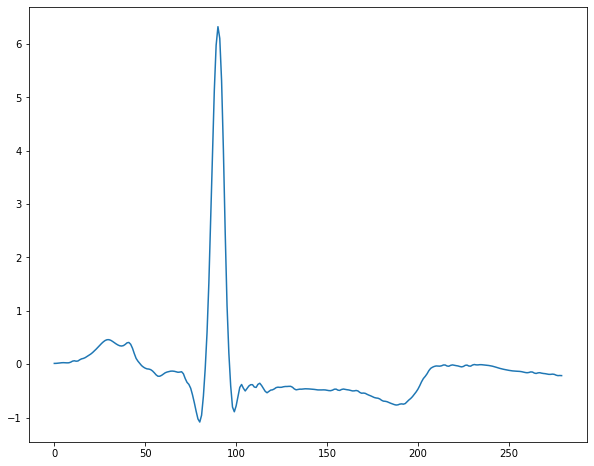

In [20]:
plt.plot(X[0])

In [21]:
X_train, X_test, y_train, y_test = tts(X, y, test_size = 0.2)

In [22]:
clas = SVC()

In [23]:
clas.fit(X_train, y_train)

SVC()

In [24]:
y_pred = clas.predict(X_test)

In [25]:
accuracy_score(y_test, y_pred)

0.9819116527037319

<AxesSubplot:>

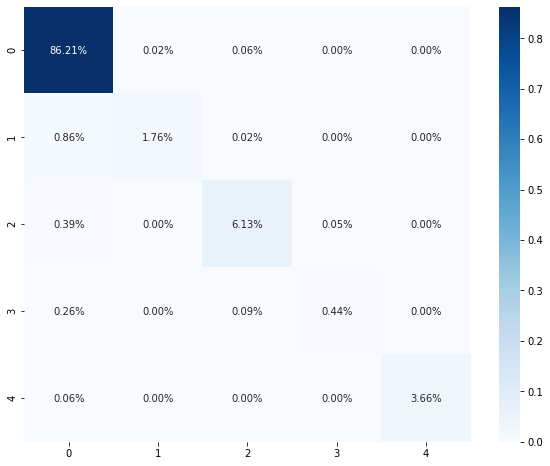

In [26]:
plt.rcParams['figure.figsize'] = (10, 8)
sns.heatmap(confusion_matrix(y_test, y_pred) / np.sum(confusion_matrix(y_test, y_pred)), cmap = 'Blues', annot = True, fmt = '.2%' )

In [27]:
pickle.dump(clas, open('stage2.sav', 'wb'))